In [1]:
# reload automaticaly external modules
%load_ext autoreload
%autoreload 2

In [2]:
from tools import *
from figure_2D import *
from figure_3D import *
from images import *

In [3]:
import sys
sys.path.append('..')
import umbrella_mesh
import linkage_vis
import load_jsondata
from configuration import *
from visualization_helper import *

In [4]:
import numpy as np

In [5]:
sys.path.append('../UmbrellaGen')
import grid_gen

### **Python file**

In [6]:
category_name = 'External'

### **Rows** and **Columns**

In [7]:
degree = 3
steps = 3
folder_name='TEST'
deployment = 'incremental'

In [8]:
minHeight = 64

In [9]:
rows, cols = 0,0

In [10]:
import mesh
base_mesh = mesh.Mesh("../../data/plane_equi.obj")
V, F = base_mesh.vertices(), base_mesh.elements()
V_3d = np.zeros((len(V), 3))
V_3d[:, :2] = V
edge_length = np.linalg.norm(V_3d[F][0, 0] - V_3d[F][0, 1])
numUmbrellas = len(F)
base_mesh_gen = V_3d.tolist(), F.tolist()

In [11]:
def myHeightFunc(numUmbrellas): 
    heights = [1] * numUmbrellas # Scale Factor of heights. Set minHeight to your desired minimum absolute height.
    for uid in range(numUmbrellas):
        # heights[uid] += (0.1 * uid**1.6 + 0.1 *(numUmbrellas - 1 - uid)**1.6)
        heights[uid] += (0.01 * uid**2 + 0.01 *(numUmbrellas - 1 - uid)**2)
    heights = [h/min(heights) for h in heights]
    return heights

In [12]:
# grid_gen.genUmbrellaWithHeights(degree, 0, 0, height_scales = [1]*numUmbrellas,minHeight = minHeight, base_mesh = base_mesh_gen, edge_length=edge_length)
grid_gen.genUmbrellaWithHeights(degree, 0, 0, height_scales = myHeightFunc(numUmbrellas),minHeight = minHeight, base_mesh = base_mesh_gen, edge_length=edge_length)

In [13]:
name = 'grid_dump'
input_path = '../UmbrellaGen/{}.json.gz'.format(name)
io, input_data, target_mesh, curr_um, plate_thickness_scaled, target_height_multiplier = parse_input(input_path, handleBoundary = False, isHex = (degree == 6), use_target_surface = False)
# Can set use_target_surface = True to add target_mesh to the curr_um class for target attraction during deployment as well as inverse design

In [14]:
init_center_pos = get_center_position(curr_um)
init_heights = curr_um.umbrellaHeights

### **Deployed** and **Undeployed**

In [15]:
deployed_cells  = list(range(31,45))
undeployed_cells = [0,1,2, 76,77,78,79,80]

---

In [16]:
active_cells    = deployed_cells + undeployed_cells
target_percents = [100]*len(deployed_cells) + [0]*len(undeployed_cells) # 0:undeployed | 100:deployed

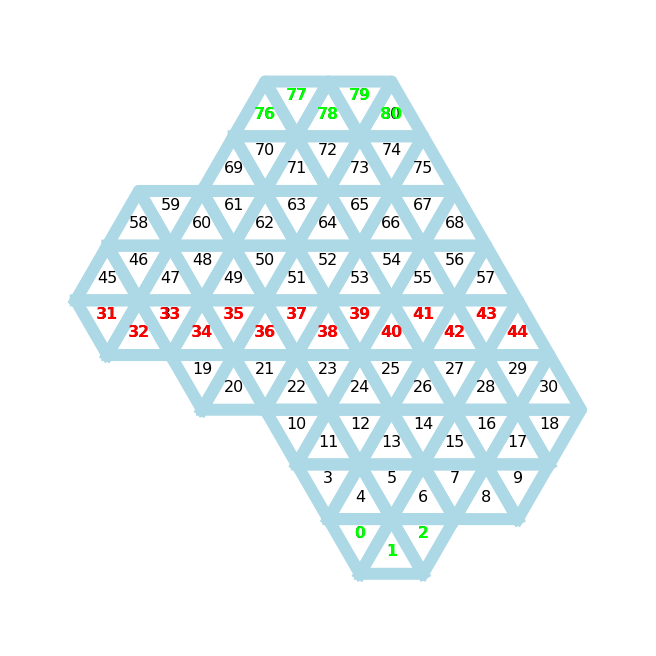

In [17]:
plot2D(input_data,
           curr_um,
           show_height=False,
           active_cells=active_cells,
           target_percents=target_percents,
           file_name = '',
           show_plot=True)

In [19]:
view3D = plot3D(curr_um, input_data)
view3D.show()

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(PointLight(color='#999999', position=(0…

In [20]:
rod_colors = get_color_field(curr_um, input_data, uidBased = False)

In [21]:
dep_weights              = set_actives_dep_weights(numUmbrellas, active_cells)
target_heights           = percent_to_height(init_heights, plate_thickness_scaled, active_cells, target_percents)
target_height_multiplier = set_target_height(numUmbrellas, active_cells, target_heights)

In [22]:
success, eqays = deploy_umbrella_pin_rigid_motion(curr_um, plate_thickness_scaled, target_height_multiplier, view3D, rod_colors, analysis = True, dep_weights=dep_weights)

In [23]:
sview_vm = plot3D_stress(curr_um, 'maxBending')
sview_vm.show()

maxBending Stresses Extrem values:
    max : 3.53e+01
    min : 0.00e+00


Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(PointLight(color='#999999', position=(0…

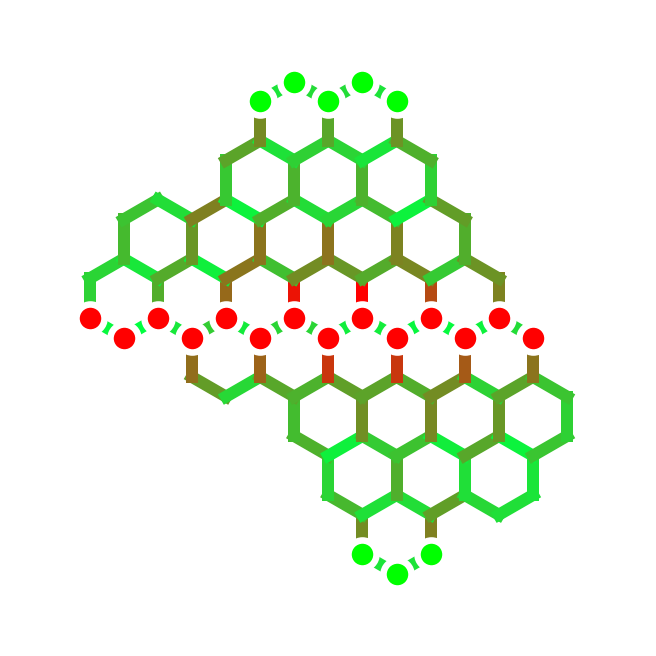

In [25]:
plot2D_stress(curr_um, input_data['umbrella_connectivity'], init_center_pos, active_cells, target_percents, show_percent=False)